In [1]:
import os
import cv2
import pandas as pd
from torch.utils.data import Dataset
import numpy as np
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
def create_video_list(base_path):
    data = []
    for label, category in enumerate(["NonViolence", "Violence"]):
        folder = os.path.join(base_path, category)
        for video_file in os.listdir(folder):
            if video_file.endswith((".mp4", ".avi", ".mov")):  # Add other formats if needed
                video_path = os.path.join(folder, video_file)
                data.append((video_path, label))
    return data

# Example usage
base_path = "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset"
video_data = create_video_list(base_path)
print(f"Total videos: {len(video_data)}")


Total videos: 2000


In [3]:
video_data[:3]

[('/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_759.mp4',
  0),
 ('/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_564.mp4',
  0),
 ('/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_126.mp4',
  0)]

In [4]:
df = pd.DataFrame(video_data,columns=["video_path","target"])

In [5]:
df

,video_path,target
0,/kaggle/input/real-life-violence-situations-da...,0
1,/kaggle/input/real-life-violence-situations-da...,0
2,/kaggle/input/real-life-violence-situations-da...,0
3,/kaggle/input/real-life-violence-situations-da...,0
4,/kaggle/input/real-life-violence-situations-da...,0
...,...,...
1995,/kaggle/input/real-life-violence-situations-da...,1
1996,/kaggle/input/real-life-violence-situations-da...,1
1997,/kaggle/input/real-life-violence-situations-da...,1
1998,/kaggle/input/real-life-violence-situations-da...,1


In [6]:
df['target'].value_counts()

target
0    1000
1    1000
Name: count, dtype: int64

In [7]:
import cv2
import pandas as pd

# Function to get total frames and duration of the video
def get_video_info(video_path):
    # Open the video using OpenCV
    video = cv2.VideoCapture(video_path)
    
    # Get the number of frames in the video
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Get the frame rate (frames per second)
    fps = video.get(cv2.CAP_PROP_FPS)
    
    # Calculate the total time of the video in seconds
    total_time = total_frames / fps if fps != 0 else 0
    
    # Release the video capture object
    video.release()
    
    return total_frames, total_time

# Function to apply on the DataFrame
def add_video_info(df):
    # Initialize lists to store the total frames and time for each video
    total_frames = []
    total_time = []
    
    # Loop through each row in the DataFrame
    for index, row in df.iterrows():
        video_path = row['video_path']  # Assuming 'video_path' is the column containing the path
        frames, time = get_video_info(video_path)
        
        total_frames.append(frames)
        total_time.append(time)
    
    # Add the new columns to the DataFrame
    df['total_frames'] = total_frames
    df['total_time'] = total_time
    
    return df

# Example usage:
# Assuming you have a DataFrame `df` with a 'video_path' column
# df = pd.DataFrame({'video_path': ['path_to_video1.mp4', 'path_to_video2.mp4']})

# Apply the function to the DataFrame to add total frames and time
df = add_video_info(df)

# Print the updated DataFrame
print(df[['video_path', 'total_frames', 'total_time']])

                                             video_path  total_frames  \
0     /kaggle/input/real-life-violence-situations-da...           125   
1     /kaggle/input/real-life-violence-situations-da...           125   
2     /kaggle/input/real-life-violence-situations-da...           150   
3     /kaggle/input/real-life-violence-situations-da...           105   
4     /kaggle/input/real-life-violence-situations-da...            55   
...                                                 ...           ...   
1995  /kaggle/input/real-life-violence-situations-da...           156   
1996  /kaggle/input/real-life-violence-situations-da...           150   
1997  /kaggle/input/real-life-violence-situations-da...           177   
1998  /kaggle/input/real-life-violence-situations-da...           123   
1999  /kaggle/input/real-life-violence-situations-da...           138   

      total_time  
0         5.0000  
1         5.0000  
2         5.0000  
3         5.0000  
4         5.0000  
...      

In [8]:
df

,video_path,target,total_frames,total_time
0,/kaggle/input/real-life-violence-situations-da...,0,125,5.0000
1,/kaggle/input/real-life-violence-situations-da...,0,125,5.0000
2,/kaggle/input/real-life-violence-situations-da...,0,150,5.0000
3,/kaggle/input/real-life-violence-situations-da...,0,105,5.0000
4,/kaggle/input/real-life-violence-situations-da...,0,55,5.0000
...,...,...,...,...
1995,/kaggle/input/real-life-violence-situations-da...,1,156,5.2000
1996,/kaggle/input/real-life-violence-situations-da...,1,150,5.0000
1997,/kaggle/input/real-life-violence-situations-da...,1,177,5.9000
1998,/kaggle/input/real-life-violence-situations-da...,1,123,4.1041


In [9]:
df.describe()

,target,total_frames,total_time
count,2000.000000,2000.000000,2000.000000
mean,0.500000,143.684500,5.252813
std,0.500125,290.743559,9.645422
min,0.000000,29.000000,1.000000
25%,0.000000,120.000000,4.880142
50%,0.500000,132.000000,5.000000
75%,1.000000,150.000000,5.000000
max,1.000000,11272.000000,375.733333


In [10]:
import pandas as pd

# Function to detect outliers in the 'total_frames' column using IQR method
def detect_outliers(df):
    # Extract the 'total_frames' column from the DataFrame
    frame_counts = df['total_frames']
    
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = frame_counts.quantile(0.25)
    Q3 = frame_counts.quantile(0.75)
    
    # Calculate the IQR
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find the outliers
    outliers = df[(frame_counts < lower_bound) | (frame_counts > upper_bound)]
    
    return outliers, lower_bound, upper_bound

# Example usage:
# Assuming your DataFrame `df` has a 'total_frames' column
outliers, lower_bound, upper_bound = detect_outliers(df)

# Display the outliers and bounds
# print("Outliers detected:")
# print(outliers)
# print(f"Lower Bound: {lower_bound}")
# print(f"Upper Bound: {upper_bound}")
outliers

,video_path,target,total_frames,total_time
4,/kaggle/input/real-life-violence-situations-da...,0,55,5.000000
17,/kaggle/input/real-life-violence-situations-da...,0,55,5.000000
35,/kaggle/input/real-life-violence-situations-da...,0,55,5.000000
64,/kaggle/input/real-life-violence-situations-da...,0,55,5.000000
86,/kaggle/input/real-life-violence-situations-da...,0,55,5.000000
...,...,...,...,...
1501,/kaggle/input/real-life-violence-situations-da...,1,11272,375.733333
1578,/kaggle/input/real-life-violence-situations-da...,1,222,7.407400
1669,/kaggle/input/real-life-violence-situations-da...,1,228,7.607600
1718,/kaggle/input/real-life-violence-situations-da...,1,4109,136.966667


In [11]:
 outliers.sort_values(by='total_frames', ascending=False)[:20]

,video_path,target,total_frames,total_time
1501,/kaggle/input/real-life-violence-situations-da...,1,11272,375.733333
988,/kaggle/input/real-life-violence-situations-da...,0,5397,179.900000
1718,/kaggle/input/real-life-violence-situations-da...,1,4109,136.966667
1409,/kaggle/input/real-life-violence-situations-da...,1,283,11.320000
1669,/kaggle/input/real-life-violence-situations-da...,1,228,7.607600
1578,/kaggle/input/real-life-violence-situations-da...,1,222,7.407400
1330,/kaggle/input/real-life-violence-situations-da...,1,222,7.407400
1442,/kaggle/input/real-life-violence-situations-da...,1,213,7.100000
1484,/kaggle/input/real-life-violence-situations-da...,1,210,7.007000
1438,/kaggle/input/real-life-violence-situations-da...,1,210,7.000000


In [12]:
upper_bound,lower_bound

(195.0, 75.0)

In [13]:
import numpy as np

# Function to calculate variance of total frames
def calculate_frame_variance(df):
    # Assuming 'total_frames' column exists after calling add_video_info function
    frame_counts = df['total_frames']
    
    # Calculate the variance of total frames
    frame_variance = np.var(frame_counts)
    
    return frame_variance

frame_variance = calculate_frame_variance(df)

print(f"Variance of frames: {frame_variance}")


Variance of frames: 84489.55095975


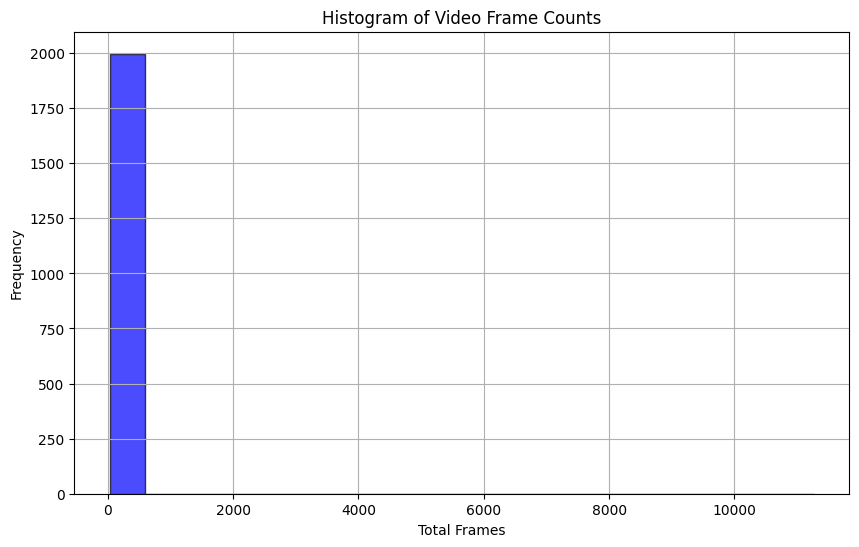

In [14]:
import matplotlib.pyplot as plt

# Function to plot histogram with custom bins and no log scaling
def plot_frame_histogram(df):
    # Extract the total frames from the DataFrame
    frame_counts = df['total_frames']
    
    # Define a custom number of bins, which is suitable for the range of frame counts
    bins = 20  # Adjust this based on your dataset, can try other values too
    
    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(frame_counts, bins=bins, color='blue', edgecolor='black', alpha=0.7)
    
    # Adding title and labels
    plt.title('Histogram of Video Frame Counts')
    plt.xlabel('Total Frames')
    plt.ylabel('Frequency')
    
    # Display grid lines and show the plot
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming your DataFrame `df` has a 'total_frames' column
plot_frame_histogram(df)


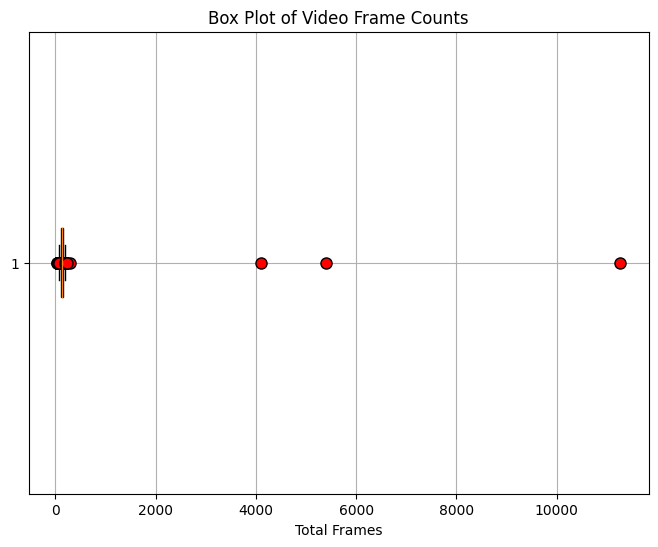

In [15]:
import matplotlib.pyplot as plt

# Function to plot box plot of total frames
def plot_frame_boxplot(df):
    # Extract the total frames from the DataFrame
    frame_counts = df['total_frames']
    
    # Plot the box plot
    plt.figure(figsize=(8, 6))
    plt.boxplot(frame_counts, vert=False, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', color='black'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                flierprops=dict(markerfacecolor='red', marker='o', markersize=8))
    
    # Adding title and labels
    plt.title('Box Plot of Video Frame Counts')
    plt.xlabel('Total Frames')
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming your DataFrame `df` has a 'total_frames' column
plot_frame_boxplot(df)


In [16]:
import pandas as pd
import cv2

# Function to get video frame size
def get_frame_size(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None, None  # Handle the case where the video cannot be opened
    
    # Get frame width and height
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    cap.release()  # Release the video capture object
    return width, height

# Apply the function to all videos in the DataFrame
df['frame_size'] = df['video_path'].apply(lambda x: get_frame_size(x))

# Split width and height into separate columns
df[['frame_width', 'frame_height']] = pd.DataFrame(df['frame_size'].tolist(), index=df.index)

# Drop the frame_size column if not needed
df.drop(columns=['frame_size'], inplace=True)

# Print the updated DataFrame
df

,video_path,target,total_frames,total_time,frame_width,frame_height
0,/kaggle/input/real-life-violence-situations-da...,0,125,5.0000,224,224
1,/kaggle/input/real-life-violence-situations-da...,0,125,5.0000,224,224
2,/kaggle/input/real-life-violence-situations-da...,0,150,5.0000,224,224
3,/kaggle/input/real-life-violence-situations-da...,0,105,5.0000,224,224
4,/kaggle/input/real-life-violence-situations-da...,0,55,5.0000,224,224
...,...,...,...,...,...,...
1995,/kaggle/input/real-life-violence-situations-da...,1,156,5.2000,670,692
1996,/kaggle/input/real-life-violence-situations-da...,1,150,5.0000,728,714
1997,/kaggle/input/real-life-violence-situations-da...,1,177,5.9000,716,720
1998,/kaggle/input/real-life-violence-situations-da...,1,123,4.1041,640,360


In [17]:
df.describe()

,target,total_frames,total_time,frame_width,frame_height
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.500000,143.684500,5.252813,508.389000,399.571000
std,0.500125,290.743559,9.645422,407.384241,234.476164
min,0.000000,29.000000,1.000000,136.000000,224.000000
25%,0.000000,120.000000,4.880142,224.000000,224.000000
50%,0.500000,132.000000,5.000000,224.000000,300.000000
75%,1.000000,150.000000,5.000000,640.000000,606.500000
max,1.000000,11272.000000,375.733333,1920.000000,1920.000000


In [18]:
from sklearn.model_selection import train_test_split

# Split into training (70%), validation (20%), and test (10%)
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['target'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['target'])

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")


Train: 1440, Validation: 360, Test: 200


In [19]:
train_df['target'].value_counts(),val_df['target'].value_counts(),test_df['target'].value_counts()

(target
 0    720
 1    720
 Name: count, dtype: int64,
 target
 1    180
 0    180
 Name: count, dtype: int64,
 target
 0    100
 1    100
 Name: count, dtype: int64)

In [20]:
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence

class VideoDataGenerator(Sequence):
    def __init__(self, video_paths, labels, batch_size, max_frames=50, frame_size=(128, 128), frame_interval=3):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.max_frames = max_frames
        self.frame_size = frame_size
        self.frame_interval = frame_interval  # To pick every 5th frame

    def __len__(self):
        return int(np.floor(len(self.video_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_video_paths = self.video_paths[index * self.batch_size: (index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size: (index + 1) * self.batch_size]

        videos = []
        for video_path in batch_video_paths:
            frames = self.load_video_frames(video_path)
            frames = self.resize_frames(frames, self.frame_size)
            frames = self.pad_video_frames(frames, self.max_frames)
            videos.append(frames)

        return np.array(videos, dtype=np.float32), np.array(batch_labels)

    def load_video_frames(self, video_path):
        frames = []
        cap = cv2.VideoCapture(video_path)
        
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame_count += 1
            
            # Select every 5th frame
            if frame_count % self.frame_interval == 0:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
        
        cap.release()
        return frames

    def resize_frames(self, frames, frame_size):
        return [cv2.resize(frame, frame_size) for frame in frames]

    def pad_video_frames(self, frames, max_frames):
        if len(frames) < max_frames:
            padding = max_frames - len(frames)
            frames.extend([np.zeros_like(frames[0])] * padding)  # Pad with empty frames
        else:
            frames = frames[:max_frames]  # Crop to max_frames
        return np.array(frames)


train_gen = VideoDataGenerator(train_df['video_path'], train_df['target'], batch_size=32, frame_interval=3)
val_gen = VideoDataGenerator(val_df['video_path'], val_df['target'], batch_size=32, frame_interval=3)
test_gen = VideoDataGenerator(test_df['video_path'], test_df['target'], batch_size=32, frame_interval=3)

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Input Layer
inputs = layers.Input(shape=(50, 128, 128, 3))  # 50 frames of 128x128 RGB images

# First block of 3D Convolutions
x = layers.Conv3D(16, kernel_size=(5, 5, 5), activation='relu', padding='same')(inputs)
x = layers.AveragePooling3D(pool_size=(2, 2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

# Second block of 3D Convolutions
x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = layers.AveragePooling3D(pool_size=(2, 2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# TimeDistributed GlobalAveragePooling2D
x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(x)

# Bidirectional LSTM layer
x = layers.Bidirectional(layers.LSTM(128))(x)
x = layers.Dropout(0.5)(x)

# Fully connected layer
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# Output layer for binary classification
outputs = layers.Dense(1, activation='sigmoid')(x)

# Create Model
model = models.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 50, 128, 128,   │         6,016 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling3d               │ (None, 25, 64, 64, 16) │             0 │
│ (AveragePooling3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25, 64, 64, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 64, 64, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 25, 64, 64, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling3d_1             │ (None, 12, 32, 32, 32) │             0 │
│ (AveragePooling3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 32, 32, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 32, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 12, 32)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       164,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,697 (787.88 KB)

 Trainable params: 201,473 (787.00 KB)

 Non-trainable params: 224 (896.00 B)

In [22]:
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',           # Path to save the model
    monitor='val_loss',                 # Metric to monitor (use 'val_accuracy' if you prefer)
    save_best_only=True,                # Only save the best model
    save_weights_only=False,            # Save the entire model (set to True to save weights only)
    mode='min',                         # Save model when val_loss is at its minimum
    verbose=1
)

In [23]:
# Train the model
history = model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=[checkpoint_callback])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/45 ━━━━━━━━━━━━━━━━━━━━ 1:59 5s/step - accuracy: 0.5063 - loss: 0.8997

[h264 @ 0x7a046c49ddc0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a046c49ddc0] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5748 - loss: 0.8105
Epoch 1: val_loss improved from inf to 0.63363, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 344s 6s/step - accuracy: 0.5766 - loss: 0.8080 - val_accuracy: 0.7045 - val_loss: 0.6336
Epoch 2/10
26/45 ━━━━━━━━━━━━━━━━━━━━ 1:43 5s/step - accuracy: 0.7427 - loss: 0.5359

[h264 @ 0x7a080c00d640] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a080c00d640] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7533 - loss: 0.5283
Epoch 2: val_loss improved from 0.63363 to 0.54234, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 312s 6s/step - accuracy: 0.7538 - loss: 0.5277 - val_accuracy: 0.7898 - val_loss: 0.5423
Epoch 3/10
18/45 ━━━━━━━━━━━━━━━━━━━━ 2:01 5s/step - accuracy: 0.8305 - loss: 0.3878

[h264 @ 0x7a09a7986ac0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a09a7986ac0] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8199 - loss: 0.4144
Epoch 3: val_loss did not improve from 0.54234
45/45 ━━━━━━━━━━━━━━━━━━━━ 309s 6s/step - accuracy: 0.8195 - loss: 0.4152 - val_accuracy: 0.7102 - val_loss: 0.5649
Epoch 4/10


[h264 @ 0x7a046c006700] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a046c006700] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8382 - loss: 0.3696
Epoch 4: val_loss improved from 0.54234 to 0.48775, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 310s 6s/step - accuracy: 0.8381 - loss: 0.3696 - val_accuracy: 0.7557 - val_loss: 0.4877
Epoch 5/10
 1/45 ━━━━━━━━━━━━━━━━━━━━ 25:51 35s/step - accuracy: 0.9062 - loss: 0.2412

[h264 @ 0x7a08303a93c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a08303a93c0] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8286 - loss: 0.3909
Epoch 5: val_loss did not improve from 0.48775
45/45 ━━━━━━━━━━━━━━━━━━━━ 305s 6s/step - accuracy: 0.8288 - loss: 0.3905 - val_accuracy: 0.7699 - val_loss: 0.4884
Epoch 6/10
 6/45 ━━━━━━━━━━━━━━━━━━━━ 6:18 10s/step - accuracy: 0.8823 - loss: 0.3003

[h264 @ 0x7a09b81d4180] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a09b81d4180] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8631 - loss: 0.3399
Epoch 6: val_loss did not improve from 0.48775
45/45 ━━━━━━━━━━━━━━━━━━━━ 321s 6s/step - accuracy: 0.8629 - loss: 0.3399 - val_accuracy: 0.5653 - val_loss: 1.4638
Epoch 7/10


[h264 @ 0x7a08000df7c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a08000df7c0] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8493 - loss: 0.3520
Epoch 7: val_loss did not improve from 0.48775
45/45 ━━━━━━━━━━━━━━━━━━━━ 317s 6s/step - accuracy: 0.8495 - loss: 0.3515 - val_accuracy: 0.6562 - val_loss: 0.9606
Epoch 8/10
 1/45 ━━━━━━━━━━━━━━━━━━━━ 26:01 35s/step - accuracy: 0.9062 - loss: 0.2328

[h264 @ 0x7a09841d9840] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a09841d9840] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8731 - loss: 0.3054
Epoch 8: val_loss did not improve from 0.48775
45/45 ━━━━━━━━━━━━━━━━━━━━ 311s 6s/step - accuracy: 0.8730 - loss: 0.3055 - val_accuracy: 0.7983 - val_loss: 0.5866
Epoch 9/10
10/45 ━━━━━━━━━━━━━━━━━━━━ 4:10 7s/step - accuracy: 0.9003 - loss: 0.2558

[h264 @ 0x7a0464051600] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a0464051600] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8813 - loss: 0.2854
Epoch 9: val_loss improved from 0.48775 to 0.41290, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 320s 6s/step - accuracy: 0.8811 - loss: 0.2856 - val_accuracy: 0.8267 - val_loss: 0.4129
Epoch 10/10
34/45 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.8892 - loss: 0.2800 

[h264 @ 0x7a082809be80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a082809be80] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8882 - loss: 0.2793
Epoch 10: val_loss did not improve from 0.41290
45/45 ━━━━━━━━━━━━━━━━━━━━ 309s 6s/step - accuracy: 0.8881 - loss: 0.2793 - val_accuracy: 0.8125 - val_loss: 0.5133


In [24]:
# Train the model
history_1 = model.fit(train_gen, validation_data=val_gen, epochs=5, callbacks=[checkpoint_callback])

Epoch 1/5
 7/45 ━━━━━━━━━━━━━━━━━━━━ 2:50 4s/step - accuracy: 0.8903 - loss: 0.2492

[h264 @ 0x7a04601d0f40] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a04601d0f40] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8974 - loss: 0.2464
Epoch 1: val_loss improved from 0.41290 to 0.32406, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 317s 6s/step - accuracy: 0.8974 - loss: 0.2466 - val_accuracy: 0.8892 - val_loss: 0.3241
Epoch 2/5


[h264 @ 0x7a08119caf80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a08119caf80] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8992 - loss: 0.2407
Epoch 2: val_loss did not improve from 0.32406
45/45 ━━━━━━━━━━━━━━━━━━━━ 320s 6s/step - accuracy: 0.8990 - loss: 0.2411 - val_accuracy: 0.7102 - val_loss: 0.6045
Epoch 3/5
25/45 ━━━━━━━━━━━━━━━━━━━━ 1:33 5s/step - accuracy: 0.9042 - loss: 0.2369

[h264 @ 0x7a046c0ab5c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a046c0ab5c0] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9036 - loss: 0.2393
Epoch 3: val_loss did not improve from 0.32406
45/45 ━━━━━━━━━━━━━━━━━━━━ 323s 6s/step - accuracy: 0.9036 - loss: 0.2395 - val_accuracy: 0.7415 - val_loss: 0.8939
Epoch 4/5
13/45 ━━━━━━━━━━━━━━━━━━━━ 2:29 5s/step - accuracy: 0.9016 - loss: 0.2365

[h264 @ 0x7a07fc1014c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a07fc1014c0] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9049 - loss: 0.2308
Epoch 4: val_loss did not improve from 0.32406
45/45 ━━━━━━━━━━━━━━━━━━━━ 314s 6s/step - accuracy: 0.9048 - loss: 0.2311 - val_accuracy: 0.6534 - val_loss: 1.4082
Epoch 5/5
 7/45 ━━━━━━━━━━━━━━━━━━━━ 3:17 5s/step - accuracy: 0.8636 - loss: 0.3149

[h264 @ 0x7a0840044400] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a0840044400] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8839 - loss: 0.2696
Epoch 5: val_loss did not improve from 0.32406
45/45 ━━━━━━━━━━━━━━━━━━━━ 311s 6s/step - accuracy: 0.8842 - loss: 0.2691 - val_accuracy: 0.7756 - val_loss: 0.6128


In [25]:
history_2 = model.fit(train_gen, validation_data=val_gen, epochs=5, callbacks=[checkpoint_callback])

Epoch 1/5
 5/45 ━━━━━━━━━━━━━━━━━━━━ 3:26 5s/step - accuracy: 0.9132 - loss: 0.1670

[h264 @ 0x7a09b810da80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a09b810da80] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9155 - loss: 0.1999
Epoch 1: val_loss did not improve from 0.32406
45/45 ━━━━━━━━━━━━━━━━━━━━ 319s 6s/step - accuracy: 0.9155 - loss: 0.2004 - val_accuracy: 0.8409 - val_loss: 0.4457
Epoch 2/5
 6/45 ━━━━━━━━━━━━━━━━━━━━ 5:43 9s/step - accuracy: 0.9263 - loss: 0.2065 

[h264 @ 0x7a08003b6e00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a08003b6e00] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9204 - loss: 0.2034
Epoch 2: val_loss did not improve from 0.32406
45/45 ━━━━━━━━━━━━━━━━━━━━ 308s 6s/step - accuracy: 0.9201 - loss: 0.2039 - val_accuracy: 0.7869 - val_loss: 0.7335
Epoch 3/5
37/45 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.9061 - loss: 0.2139

[h264 @ 0x7a085c17fb40] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a085c17fb40] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9074 - loss: 0.2142
Epoch 3: val_loss did not improve from 0.32406
45/45 ━━━━━━━━━━━━━━━━━━━━ 308s 6s/step - accuracy: 0.9075 - loss: 0.2143 - val_accuracy: 0.8239 - val_loss: 0.4737
Epoch 4/5
21/45 ━━━━━━━━━━━━━━━━━━━━ 2:18 6s/step - accuracy: 0.9237 - loss: 0.2073

[h264 @ 0x7a047002f300] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a047002f300] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9232 - loss: 0.2095
Epoch 4: val_loss did not improve from 0.32406
45/45 ━━━━━━━━━━━━━━━━━━━━ 303s 6s/step - accuracy: 0.9231 - loss: 0.2097 - val_accuracy: 0.8011 - val_loss: 0.5510
Epoch 5/5
 2/45 ━━━━━━━━━━━━━━━━━━━━ 3:14 5s/step - accuracy: 0.9375 - loss: 0.1394  

[h264 @ 0x7a0838059a00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x7a0838059a00] error while decoding MB 98 31


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9148 - loss: 0.2007
Epoch 5: val_loss did not improve from 0.32406
45/45 ━━━━━━━━━━━━━━━━━━━━ 314s 6s/step - accuracy: 0.9146 - loss: 0.2011 - val_accuracy: 0.8352 - val_loss: 0.4240


In [26]:
model.save("/kaggle/working/violnce_model.keras")

In [27]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the model
model_path = '/kaggle/working/best_model.keras'
model = load_model(model_path)

loss, accuracy = model.evaluate(test_gen)

# Print the test loss and accuracy
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.8633 - loss: 0.2897
Test Loss: 0.29301515221595764
Test Accuracy: 0.859375
